In [254]:
# import numpy as np
# from numpy import fft
# from math import pi
import matplotlib.pyplot as plt

In [263]:
#! /bin/python3

__author__ = "Mikael Mortensen <mikaem@math.uio.no>"
__date__ = "2015-01-02"
__copyright__ = "Copyright (C) 2014-2018 " + __author__
__license__ = "GNU Lesser GPL version 3 or any later version"
#pylint: disable=reimported,redefined-outer-name
from time import time
from numpy import *
import numpy as np
from numpy.fft import fftfreq, fft, ifft, irfft2, rfft2
from mpi4py import MPI

try:
    from pyfftw.interfaces.numpy_fft import fft, ifft, irfft2, rfft2
    import pyfftw
    pyfftw.interfaces.cache.enable()

except ImportError:
    pass

nu = 0.000625
T = 0.1
dt = 0.01
N = 2**6
comm = MPI.COMM_WORLD
num_processes = comm.Get_size()
print(f"num processes is {num_processes}")
rank = comm.Get_rank()
Np = N // num_processes
X = mgrid[rank*Np:(rank+1)*Np, :N, :N].astype(float)*2*pi/N
U = empty((3, Np, N, N))
U_hat = empty((3, N, Np, N//2+1), dtype=complex)
P = empty((Np, N, N))
P_hat = empty((N, Np, N//2+1), dtype=complex)
U_hat0 = empty((3, N, Np, N//2+1), dtype=complex)
U_hat1 = empty((3, N, Np, N//2+1), dtype=complex)
dU = empty((3, N, Np, N//2+1), dtype=complex)
Uc_hat = empty((N, Np, N//2+1), dtype=complex)
Uc_hatT = empty((Np, N, N//2+1), dtype=complex)
curl = empty((3, Np, N, N))
cross = empty((3, Np, N, N))

kx = fftfreq(N, 1./N)
kz = kx[:(N//2+1)].copy()
kz[-1] *= -1
K = array(meshgrid(kx, kx[rank*Np:(rank+1)*Np], kz, indexing='ij'), dtype=int)
K2 = sum(K*K, 0, dtype=int)
K_over_K2 = K.astype(float) / where(K2 == 0, 1, K2).astype(float)
kmax_dealias = 2./3.*(N//2+1)
dealias = array((abs(K[0]) < kmax_dealias)*(abs(K[1]) < kmax_dealias)*
                (abs(K[2]) < kmax_dealias), dtype=bool)
a = [1./6., 1./3., 1./3., 1./6.]
b = [0.5, 0.5, 1.]

def fftn_mpi(u, fu):
    Uc_hatT[:] = rfft2(u, axes=(1, 2))
    fu[:] = rollaxis(Uc_hatT.reshape(Np, num_processes, Np, N//2+1), 1).reshape(fu.shape)
    comm.Alltoall(MPI.IN_PLACE, [fu, MPI.DOUBLE_COMPLEX])
    fu[:] = fft(fu, axis=0)
    return fu

def ifftn_mpi(fu, u):
    Uc_hat[:] = ifft(fu, axis=0)
    comm.Alltoall(MPI.IN_PLACE, [Uc_hat, MPI.DOUBLE_COMPLEX])
    Uc_hatT[:] = rollaxis(Uc_hat.reshape((num_processes, Np, Np, N//2+1)), 1).reshape(Uc_hatT.shape)
    u[:] = irfft2(Uc_hatT, axes=(1, 2))
    return u

def Cross(a, b, c):
    c[0] = fftn_mpi(a[1]*b[2]-a[2]*b[1], c[0])
    c[1] = fftn_mpi(a[2]*b[0]-a[0]*b[2], c[1])
    c[2] = fftn_mpi(a[0]*b[1]-a[1]*b[0], c[2])
    return c
#@profile
def Curl(a, c):
    c[2] = ifftn_mpi(1j*(K[0]*a[1]-K[1]*a[0]), c[2])
    c[1] = ifftn_mpi(1j*(K[2]*a[0]-K[0]*a[2]), c[1])
    c[0] = ifftn_mpi(1j*(K[1]*a[2]-K[2]*a[1]), c[0])
    return c
#@profile
def ComputeRHS(dU, rk):
    if rk > 0:
        for i in range(3):
            U[i] = ifftn_mpi(U_hat[i], U[i])
    curl[:] = Curl(U_hat, curl)
    dU = Cross(U, curl, dU)
    dU *= dealias
    P_hat[:] = sum(dU*K_over_K2, 0, out=P_hat)
    dU -= P_hat*K
    dU -= nu*K2*U_hat
    return dU

U[0] = sin(X[0])*cos(X[1])*cos(X[2])
U[1] = -cos(X[0])*sin(X[1])*cos(X[2])
U[2] = 0
for i in range(3):
    U_hat[i] = fftn_mpi(U[i], U_hat[i])

# t = 0.0
# tstep = 0
# t0 = time()
# while t < T-1e-8:
#     t += dt
#     tstep += 1
#     U_hat1[:] = U_hat0[:] = U_hat
#     for rk in range(4):
#         dU = ComputeRHS(dU, rk)

#         if rk < 3:
#             U_hat[:] = U_hat0 + b[rk]*dt*dU
#         U_hat1[:] += a[rk]*dt*dU
#     U_hat[:] = U_hat1[:]
#     for i in range(3):
#         U[i] = ifftn_mpi(U_hat[i], U[i])
        
#     energy = np.sum(U * U) * (2 * pi)**3 / (2 * N**3)
#     print(energy)

# k = comm.reduce(0.5*sum(U*U)*(1./N)**3)
# if rank == 0:
#     print("Time = {}".format(time()-t0))
#     assert round(k - 0.124953117517, 7) == 0


num processes is 1


In [267]:
dU = ComputeRHS(dU, 0)
for i in range(3):
    cross[i] = ifftn_mpi(dU[i], cross[i])
    
print("dU expected value")
print(np.sum(np.abs(cross)))
for i in range(3):
    print(np.sum(np.abs(cross[i])))


dU expected value
43247.14643917304
13209.69217909202
13209.692179092015
16827.762080988978


In [265]:
# for i in range(3):
#     U[i] = ifftn_mpi(U_hat[i], U[i])
curl[:] = Curl(U_hat, curl)
dU = Cross(U, curl, dU)

for i in range(3):
    cross[i] = ifftn_mpi(dU[i], cross[i])

    
print("curl terms")
print(np.sum(np.abs(curl[0, :, :, :])))
print(np.sum(np.abs(curl[1])))
print(np.sum(np.abs(curl[2])))

print("===cross results===")
print(np.sum(np.abs(cross)))
print(np.sum(np.abs(cross[0])))
print(np.sum(np.abs(cross[1])))
print(np.sum(np.abs(cross[2])))

curl terms
67473.49999867819
67473.49999867819
134946.99999735638
===cross results===
124762.15772293761
41587.3859076459
41587.385907645905
41587.38590764589


In [230]:
# K[0, :, 0, 0]

In [231]:
# K[1, 0, :, 0]

In [232]:
# K[2, 0, 0, :]

In [233]:
# X[0, :, 0, 0]

In [234]:
# X[1, 0, :, 0]

In [235]:
# X[2, 0, 0, :]

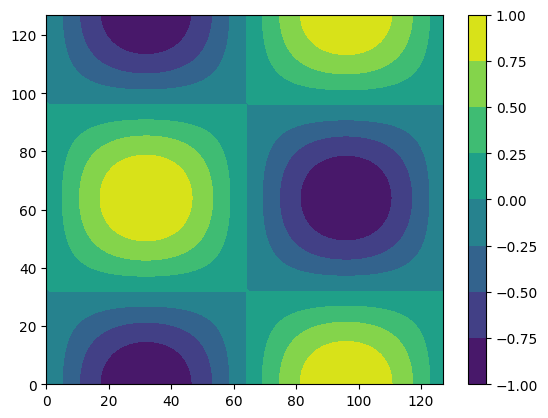

In [236]:
plt.contourf(curl[0, :, :, 32])
plt.colorbar()

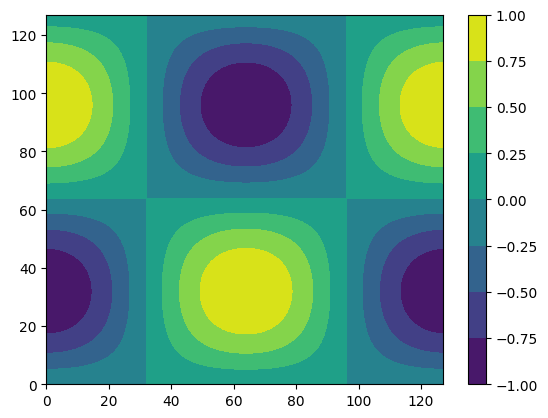

In [237]:
plt.contourf(curl[1, :, :, 32])
plt.colorbar()

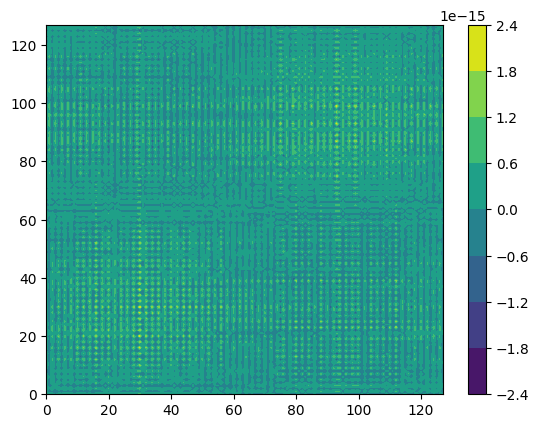

In [238]:
plt.contourf(curl[2, :, :, 32])
plt.colorbar()

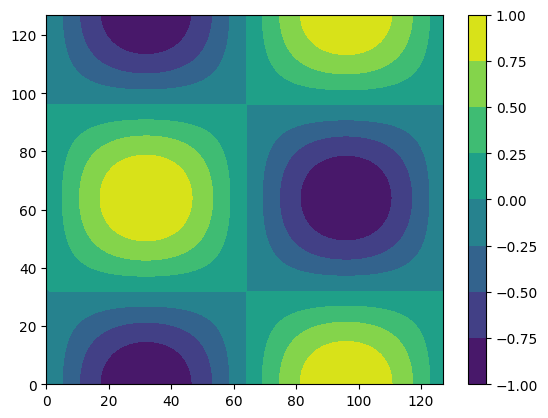

In [239]:
plt.contourf(U[0, :, :, 64].transpose())
plt.colorbar()

In [240]:
# plt.contourf(U[1, :, :, 32].transpose())
# plt.colorbar()

In [241]:
# plt.contourf(U[2, :, :, 32])
# plt.colorbar()

In [242]:
# def fftn_single(u, fu):
#     fu[:] = fft.rfftn (u , axes =( 0 ,1 , 2 ) )
#     return fu

# def ifftn_single(fu, u):
#     u[:] = fft.irfftn ( fu , axes =( 0 ,1 , 2 ) )
#     return u

In [243]:
# u = np.sin(X[0])
# uback = np.zeros((N, N, N))
# uhat = np.zeros((N, N, kn), dtype = complex)

In [244]:
# fftn_single(u, uhat);
# ifftn_single(uhat, uback);

# print(uhat.sum())
# print(uhat.shape)

In [245]:
# plt.contourf(u[:, :, 0].transpose())

In [246]:
# plt.contourf(uback[:, :, 0].transpose())

In [247]:
# def dot_arr3(left: np.ndarray, right: np.ndarray, out: np.ndarray):
#     return np.sum(left * right, axis = 0, out = out)

# def Curl(a, c):
#     c[2] = ifftn_single(1j*(K[0]*a[1]-K[1]*a[0]), c[2])
#     c[1] = ifftn_single(1j*(K[2]*a[0]-K[0]*a[2]), c[1])
#     c[0] = ifftn_single(1j*(K[1]*a[2]-K[2]*a[1]), c[0])
#     return c

# def forcing(
#     U: np.ndarray,
#     U_hat: np.ndarray,
#     curl: np.ndarray,
#     f_1 :np.ndarray,
#     f_2 :np.ndarray,
#     f_u :np.ndarray,
#     f_u_hat :np.ndarray,
#     epsilon_1: float,
#     epsilon_2: float,
# ):
#     # curl here is vorcitiy (omega) in x-space
#     curl[:] = Curl(U_hat, curl)

#     # compute some dot products
#     u_dot_omega[:] = dot_arr3(U, curl, u_dot_omega)
#     u_dot_u[:] = dot_arr3(U, U, u_dot_u)
#     omega_dot_omega[:] = dot_arr3(curl, curl, omega_dot_omega)

#     f_1[:] = (u_dot_omega * curl)
#     f_1[:] -= (omega_dot_omega * U)

#     f_2[:] = u_dot_omega * U
#     f_2[:] -= u_dot_u * curl


#     # construct final f_u vector
#     f_u[:] = (epsilon_1  * f_1[:]) + (epsilon_2 * f_2[:])

#     # go back to fourier space
#     for i in reversed(range(0,3)):
#         f_u_hat[i] = fftn_single(f_u[i], f_u_hat[i])

# #     return f_u_hat[:]
#     return U_hat[:]


In [248]:
# def taylor_green(U: np.ndarray, X: np.ndarray, U_hat: np.ndarray):
#     U[0] = np.sin(X[0])*np.cos(X[1])*np.cos(X[2])
#     U[1] = -np.cos(X[0])*np.sin(X[1])*np.cos(X[2])
#     U[2] = 0

#     for i in reversed(range(0,3)):
#         U_hat[i] = fftn_single(U[i], U_hat[i])
#     return U

In [249]:
# # forcing(U, U_hat, curl, f_1, f_2, f_u, f_u_hat, 1., 1.);
# forcing(U, U_hat, curl, f_1, f_2, f_u, f_u_hat, 0., -2056376780.81);
# print(np.sum(np.abs(f_1)))
# print(np.sum(np.abs(f_2)))
# print(np.sum(np.abs(f_u)))

In [250]:
def _contour3(array):
    I = int(N / 2) -1
    
    fig, ax = plt.subplots(1,3, figsize=(12,5))

    for i in range(3):
        p = ax[i].contourf(array[i, :, :, I].transpose())
        plt.colorbar(p, ax=ax[i])

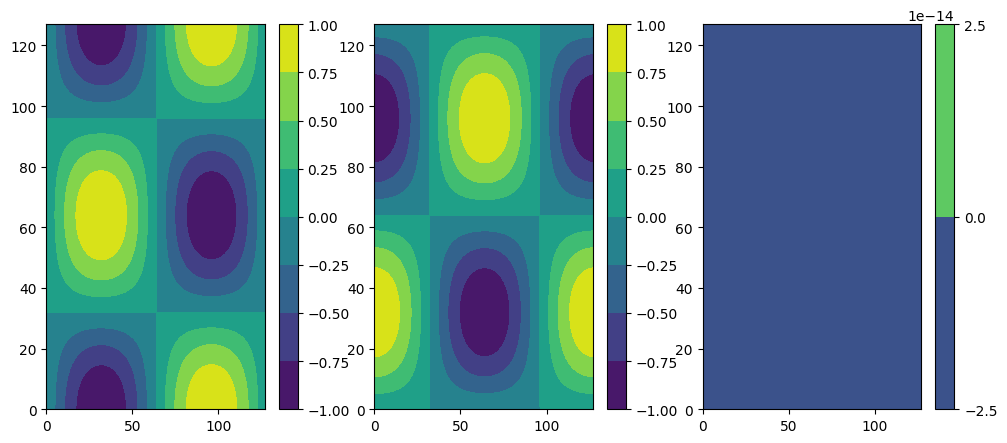

In [251]:
_contour3(U)

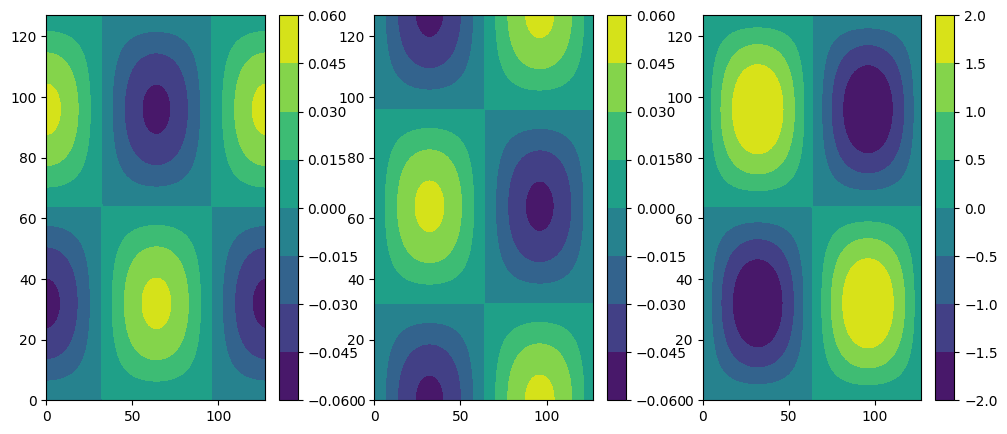

In [252]:
_contour3(curl)

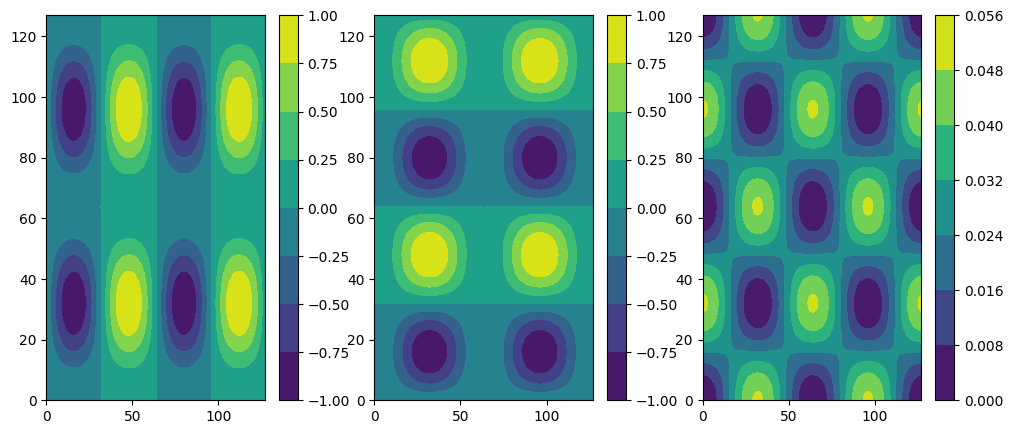

In [253]:
_contour3(cross)

In [203]:
np.sum(np.abs(curl[0, :, :, :])) / N**3

0.25785687568367777

In [204]:
np.max(curl[0, :, :, 63])

0.04906767432741358

In [205]:
def _line3(array):
    I = int(N / 2) -1
    print(I)
#     slices = [
#         [:, I, I, 1],
#         [I, :, I, 2],
#         [I, I, :, 3]
#     ]
    
    fig, ax = plt.subplots(1,3, figsize=(12,5))
    
    ax[0].plot(
        range(N),
        array[0, :, I, I]
    )
    ax[1].plot(
        range(N),
        array[1, I, :, I]
    )
    ax[2].plot(
        range(N),
        array[2, I, I, :]
    )

#     return fig

63


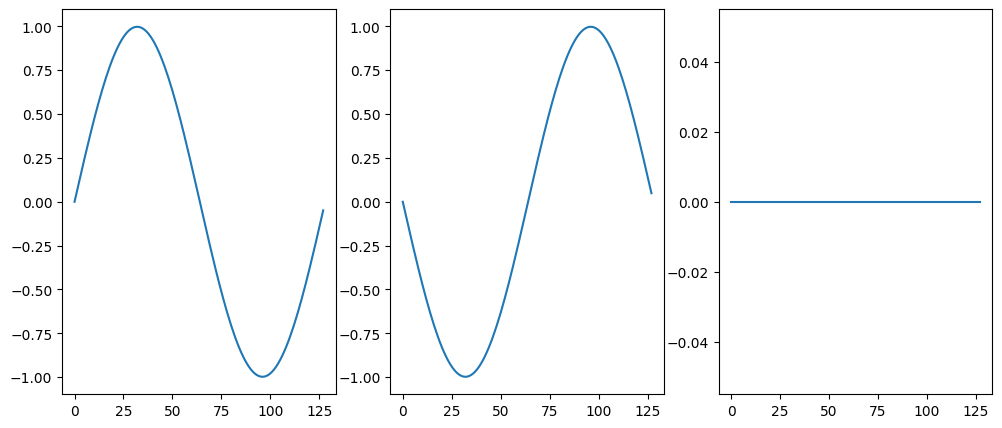

In [206]:
_line3(U)

63


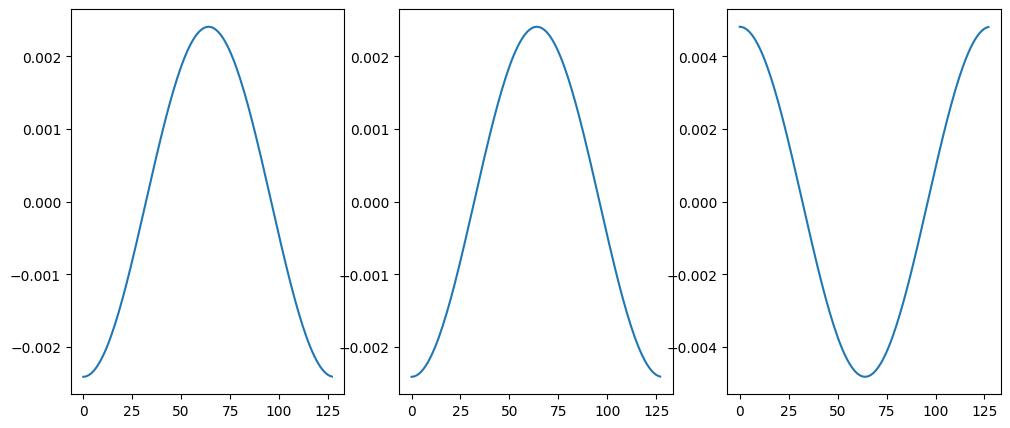

In [207]:
_line3(curl)

63


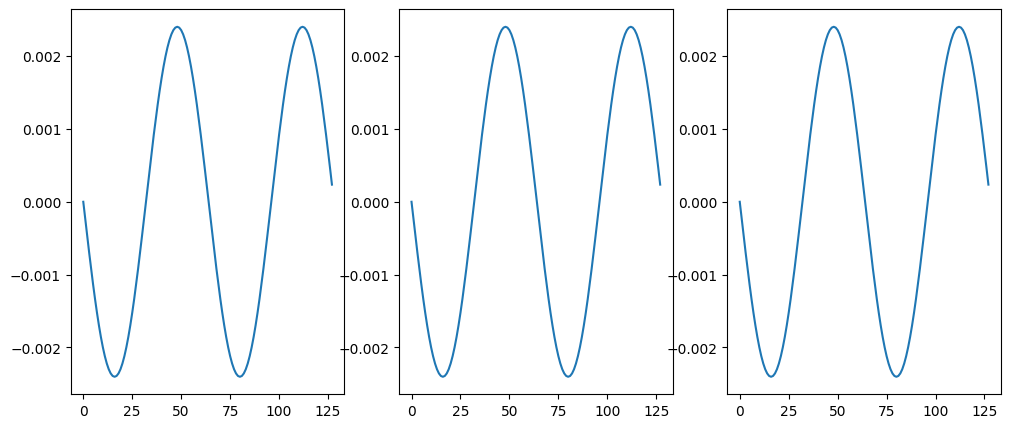

In [219]:
_line3(cross)